# Forest

Tinkering around with the forest data. 

Required python packages:
* polars (1.26.0)
* seaborn (0.13.2)


In [1]:
import polars as pl

In [2]:
df = pl.read_csv("./covtype.csv")

cover_type_map = {
    1: "Spruce/Fir",
    2: "Lodgepole Pine",
    3: "Ponderosa Pine",
    4: "Cottonwood/Willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz",
}
wilderness_map = {
    1: "Rawah",
    2: "Neota",
    3: "Comanche",
    4: "Cache la Poudre"
}


print(f"Number of data points: {len(df)} | Number of Tree Types: {len(df["Cover_Type"].unique())}")
print(f"Columns:{df.columns}")
print("\n", df.head())

Number of data points: 581012 | Number of Tree Types: 7
Columns:['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']

 shape: (5, 55)
┌─────

In [ ]:
def merge_columns(
    df: pl.DataFrame, col_name_pattern: str, as_alias: str
) -> pl.DataFrame:
    """Utility function to combine columns with similar naming pattern into a new, single column"""
    # print("Selected", df.select(col_name_pattern))
    return df.with_columns(
        pl.concat_list(df.select(col_name_pattern)).list.arg_max().alias(as_alias)
    )

In [4]:
# for plotting, merge binary columns of wilderness areas (1-4) to single int col
df = merge_columns(
    df, col_name_pattern="^Wilderness_Area\\d+$", as_alias="Wilderness_Area"
)
# merge all soil types
# df = merge_columns(df, col_name_pattern="^Soil_Type\\d+$", as_alias="Soil_Type")

In [5]:
df = df.select(pl.col("Wilderness_Area") + 1, pl.col("Cover_Type"))

In [ ]:
import seaborn as sns

PAL = "BrBG_r"
sns.set_style("dark")

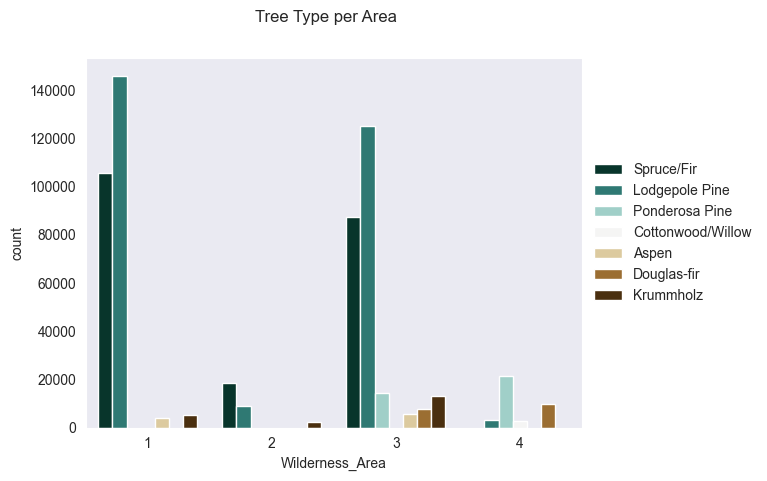

In [8]:
plt = sns.countplot(data=df, x="Wilderness_Area", hue="Cover_Type", palette=PAL)
plt.figure.suptitle("Tree Type per Area")
# loc = which corner of legend is used for placing legend
# bbox to anchor = coordinates for legend. 0,0 = origin ; 1,1 = top right corner of plot
plt.legend(labels=cover_type_map.values(), frameon=False, loc="upper left", bbox_to_anchor=(1, 0.75))
# plt.set_xticks(ticks=wilderness_map.keys(), labels=wilderness_map.values())

In [ ]:
# heatmap
cm = (
    df.pivot(  # .select(pl.col("Wilderness_Area")+1, pl.col("Cover_Type"))
        index="Wilderness_Area",
        on="Cover_Type",
        values="Cover_Type",
        # aggregate_function="len",
        aggregate_function="len",
        maintain_order=True,
        sort_columns=True,
    )
    .sort("Wilderness_Area")
    .fill_null(0)
)
# print(cm)
cm = cm[:, 1:]  # hack: hide column with wilderness area indices
print(cm)

shape: (4, 7)
┌────────┬────────┬───────┬──────┬──────┬──────┬───────┐
│ 1      ┆ 2      ┆ 3     ┆ 4    ┆ 5    ┆ 6    ┆ 7     │
│ ---    ┆ ---    ┆ ---   ┆ ---  ┆ ---  ┆ ---  ┆ ---   │
│ u32    ┆ u32    ┆ u32   ┆ u32  ┆ u32  ┆ u32  ┆ u32   │
╞════════╪════════╪═══════╪══════╪══════╪══════╪═══════╡
│ 105717 ┆ 146197 ┆ 0     ┆ 0    ┆ 3781 ┆ 0    ┆ 5101  │
│ 18595  ┆ 8985   ┆ 0     ┆ 0    ┆ 0    ┆ 0    ┆ 2304  │
│ 87528  ┆ 125093 ┆ 14300 ┆ 0    ┆ 5712 ┆ 7626 ┆ 13105 │
│ 0      ┆ 3026   ┆ 21454 ┆ 2747 ┆ 0    ┆ 9741 ┆ 0     │
└────────┴────────┴───────┴──────┴──────┴──────┴───────┘


Text(0.5, 0.98, 'Tree Density in Wilderness Areas')

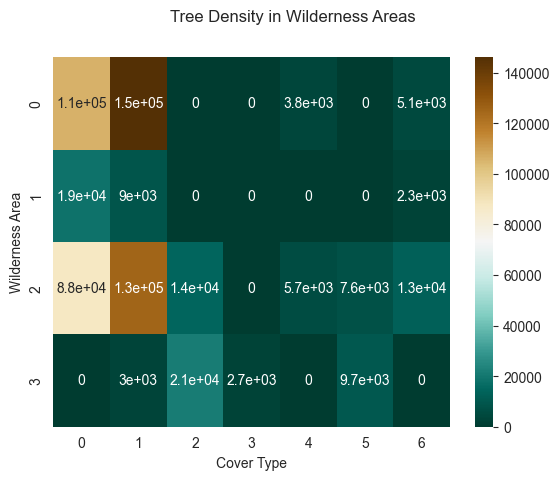

In [25]:
# normalise values [0,1] per row to better show distribution per area
# FIX: this seems wrong (does not add up to 1)
# cm_norm = cm.with_columns(
#     [((pl.all() - pl.all().min()) / (pl.all().max() - pl.all().min()))]
# )
# print(f"Normalised Heatmap\n{cm_norm}")
# TODO: remove once fixed
cm_norm = cm

# fmt=".00f" only for int
# cbar=False to turn off colour bar
plot = sns.heatmap(cm_norm, annot=True, cmap=PAL)
plot.set_ylabel("Wilderness Area")
# plot.set_yticks(ticks=wilderness_map.keys(), labels=wilderness_map.values())
plot.set_xlabel("Cover Type")
# plot.set_xticklabels(cover_type_map.values())
plot.figure.suptitle("Tree Density in Wilderness Areas")